In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/output_only_tech.json /content/
!cp -r /content/drive/MyDrive/scored_campaigns.json /content/

## Downsize Training data using one-shot classification to relevance to blurb

Since one campaign can have thousands of comments from youtube videos related to the campaign, and we do not have the computing power to process all of those campaigns together. We need to essentially score each comment according to its relevance with the campaign blurb. This will allows us to filter away the comments which are not related to the blurb/campaign.


In [ ]:
import json
from transformers import pipeline
from tqdm.auto import tqdm
from collections import defaultdict

# config
INPUT_JSON       = "output_only_tech.json"
OUTPUT_JSON      = "scored_campaigns.json"
TEXT_FIELD       = "blurb"           # which field holds your campaign description
CANDIDATE_LABELS = ["about campaign", "not about campaign"]
BATCH_SIZE       = 200               # tune to your GPU memory

def main():
    # 1) Load campaigns
    with open(INPUT_JSON, "r", encoding="utf-8") as f:
        campaigns = json.load(f)

    # 2) Flatten comments into one list with campaign index
    flat_comments = []
    for idx, camp in enumerate(campaigns):
        desc = camp.get(TEXT_FIELD, "")
        for c in camp.get("comments", []):
            text = c.get("comment", "").strip()
            if not text:
                continue
            flat_comments.append({
                "campaign_idx": idx,
                "youtube_vid":  c.get("youtube_vid"),
                "comment":      text,
                "author":       c.get("author"),
                "description":  desc,
                # we'll add "score" here after classification
            })

    # 3) Init zero-shot pipeline on GPU
    classifier = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0
    )

    # 4) Classify in batches with a tqdm bar, append score to each flat_comment
    for start in tqdm(range(0, len(flat_comments), BATCH_SIZE), desc="Classifying comments"):
        batch = flat_comments[start:start + BATCH_SIZE]
        sequences = [x["comment"] for x in batch]
        results = classifier(
            sequences=sequences,
            candidate_labels=CANDIDATE_LABELS,
            multi_label=False,
            batch_size=BATCH_SIZE
        )
        for i, out in enumerate(results):
            score = out["scores"][out["labels"].index("about campaign")]
            flat_comments[start + i]["score"] = score

    # 5) Group all scored comments back into their campaigns
    grouped = defaultdict(list)
    for c in flat_comments:
        grouped[c["campaign_idx"]].append({
            "youtube_vid": c["youtube_vid"],
            "comment":     c["comment"],
            "author":      c["author"],
            "score":       c["score"],    # keep the score
        })

    # 6) Reconstruct campaigns, replacing comments with scored-comments list
    for idx, camp in enumerate(tqdm(campaigns, desc="Reconstructing campaigns")):
        camp["comments"] = grouped.get(idx, [])

    # 7) Write out scored campaigns
    with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
        json.dump(campaigns, f, ensure_ascii=False, indent=2)

    print(f"\n✅ Done! Scored campaigns saved to '{OUTPUT_JSON}'")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Classifying comments:   0%|          | 0/4284 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Reconstructing campaigns:   0%|          | 0/206 [00:00<?, ?it/s]


✅ Done! Scored campaigns saved to 'scored_campaigns.json'


In [4]:
import json
from transformers import pipeline
from tqdm.auto import tqdm
from collections import defaultdict

# ─── CONFIG ─────────────────────────────────────────────────────────────
INPUT_JSON       = "output_only_tech.json"
EXISTING_JSON    = "scored_campaigns.json"
OUTPUT_JSON      = "merged_scored.json"
TEXT_FIELD       = "blurb"
CANDIDATE_LABELS = ["about campaign", "not about campaign"]
BATCH_SIZE       = 100
# ────────────────────────────────────────────────────────────────────────

def main():
    # 1) Load new and existing campaigns
    with open(INPUT_JSON, "r", encoding="utf-8") as f:
        new_campaigns = json.load(f)
    try:
        with open(EXISTING_JSON, "r", encoding="utf-8") as f:
            existing_campaigns = json.load(f)
    except FileNotFoundError:
        existing_campaigns = None

    # 2) Flatten only comments that need scoring
    flat_to_score = []
    for idx, camp in enumerate(new_campaigns):
        desc = camp.get(TEXT_FIELD, "")
        # build lookup of any pre-scored comments
        seen = {}
        if existing_campaigns and idx < len(existing_campaigns):
            for old in existing_campaigns[idx].get("comments", []):
                key = (old["youtube_vid"], old["comment"].strip())
                if "score" in old:
                    seen[key] = old["score"]

        for c in camp.get("comments", []):
            raw = c.get("comment", "")
            comment = raw.strip()
            # skip empty text or already-scored
            if not comment or "score" in c:
                continue

            key = (c.get("youtube_vid"), comment)
            if key in seen:
                # carry over existing score
                c["score"] = seen[key]
            else:
                flat_to_score.append({
                    "campaign_idx": idx,
                    "youtube_vid":  c.get("youtube_vid"),
                    "comment":      comment,
                    "author":       c.get("author"),
                    "description":  desc,
                })

    if flat_to_score:
        # 3) Initialize zero-shot pipeline
        classifier = pipeline(
            "zero-shot-classification",
            model="facebook/bart-large-mnli",
            device=0
        )

        # 4) Classify in batches (skip any empty batch!)
        for start in tqdm(range(0, len(flat_to_score), BATCH_SIZE), desc="Scoring new comments"):
            batch = flat_to_score[start:start + BATCH_SIZE]
            seqs  = [x["comment"] for x in batch]
            if not seqs:
                continue  # nothing to score here

            results = classifier(
                sequences=seqs,
                candidate_labels=CANDIDATE_LABELS,
                multi_label=False,
                batch_size=len(seqs)
            )
            for i, out in enumerate(results):
                score = out["scores"][out["labels"].index("about campaign")]
                flat_to_score[start + i]["score"] = score

        # 5) Build lookup of newly scored comments
        new_scores = {
            (c["campaign_idx"], c["youtube_vid"], c["comment"]): c["score"]
            for c in flat_to_score
        }

        # 6) Merge back into new_campaigns
        for idx, camp in enumerate(new_campaigns):
            for c in camp.get("comments", []):
                key = (idx, c.get("youtube_vid"), c.get("comment", "").strip())
                if key in new_scores:
                    c["score"] = new_scores[key]

    # 7) Write out
    with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
        json.dump(new_campaigns, f, ensure_ascii=False, indent=2)

    print(f"✅ Done! Merged scores written to '{OUTPUT_JSON}'")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Scoring new comments:   0%|          | 0/8555 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Done! Merged scores written to 'merged_scored.json'


In [5]:
!cp -r /content/merged_scored.json /content/drive/MyDrive/

In [ ]:
import torch
torch.cuda.empty_cache()

162


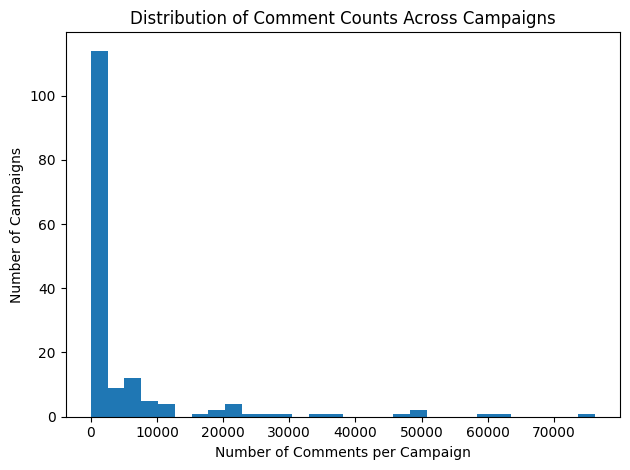

In [ ]:
import json
import matplotlib.pyplot as plt

# ─── CONFIG ─────────────────────────────────────────────────────────────
INPUT_JSON = "scored_campaigns.json"   # or "campaigns.json"
# INPUT_JSON = "output_only_tech.json"
# ────────────────────────────────────────────────────────────────────────

# 1) Load your campaigns
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    campaigns = json.load(f)

# 2) Compute comment‐counts
comment_counts = [len(camp.get("comments", [])) for camp in campaigns if 0 < len(camp.get("comments", []))]

print(len(comment_counts))

# 3) Plot histogram
plt.figure()
plt.hist(comment_counts, bins=30)
plt.xlabel("Number of Comments per Campaign")
plt.ylabel("Number of Campaigns")
plt.title("Distribution of Comment Counts Across Campaigns")
plt.tight_layout()
plt.show()

## Train the Model (Attempt 1)

- Finetune a BERT classification model ("bert-base-uncased") on the following settings:
  * per_device_train_batch_size=8
  * learning_rate=2e-5
  * num_train_epochs=3
  * weight_decay=0.01

Outcome: model defaulted to labelling all campaigns as successful.

In [ ]:
!pip install datasets

In [ ]:
!pip install -U transformers

In [ ]:
!pip install evaluate

In [ ]:
import json
from sklearn.model_selection import train_test_split

# 1. load your already-filtered campaigns
with open("filtered_campaigns.json") as f:
    campaigns = json.load(f)

# 2. build a list of (text, label)
examples = []
for camp in campaigns:
    comments = [c["comment"] for c in camp["comments"]]
    # join up to, say, the first 50 comments with a separator
    text = " ".join(comments[:50])
    label = 1 if camp["success"] else 0
    examples.append({"text": text, "label": label})

# 3. split into train/val (e.g. 80/20)
train_examples, val_examples = train_test_split(
    examples, test_size=0.2, stratify=[e["label"] for e in examples], random_state=42
)

In [ ]:
from datasets import Dataset

train_ds = Dataset.from_list(train_examples)
val_ds   = Dataset.from_list(val_examples)

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(ex):
    return tokenizer(
        ex["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)

# tell Trainer which columns to use:
train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")
train_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
val_ds.set_format("torch",   columns=["input_ids","attention_mask","labels"])

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from evaluate import load
import numpy as np

# 1) Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

# 2) Define TrainingArguments (make sure your transformers version supports these args)
training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True,
    do_eval=True,
    eval_steps=500,             # run eval every N steps
    save_steps=500,             # checkpoint every N steps
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[],
)

# 3) Metrics
metric_acc = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric_acc.compute(predictions=preds, references=labels)

# 4) Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,     # your torch.Dataset or HF Dataset
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

# 5) Train & evaluate
trainer.train()
trainer.evaluate()
trainer.save_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


In [ ]:
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np

# ─── 1. LOAD & SPLIT DATA ────────────────────────────────────────────────────
with open("filtered_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

examples = []
for camp in campaigns:
    comments = [c["comment"] for c in camp["comments"]]
    text = " ".join(comments[:50])
    label = 1 if camp["success"] else 0
    examples.append({"text": text, "label": label})

train_exs, val_exs = train_test_split(
    examples,
    test_size=0.2,
    stratify=[e["label"] for e in examples],
    random_state=42
)

# ─── 2. TOKENIZE & BUILD TORCH DATASETS ────────────────────────────────────
MODEL_NAME = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(texts):
    # returns a dict of lists: {"input_ids": [...], "attention_mask": [...]}
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_texts  = [e["text"] for e in train_exs]
train_labels = [e["label"] for e in train_exs]
train_enc    = tokenize_batch(train_texts)

val_texts    = [e["text"] for e in val_exs]
val_labels   = [e["label"] for e in val_exs]
val_enc      = tokenize_batch(val_texts)

class CampaignDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx])
                for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CampaignDataset(train_enc, train_labels)
val_dataset   = CampaignDataset(val_enc,   val_labels)

# ─── 3. MODEL & TRAINER SETUP ───────────────────────────────────────────────
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True,
    do_eval=True,
    eval_steps=500,
    save_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]       # disable WandB / TensorBoard
)

# Simple accuracy metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# ─── 4. TRAIN & SAVE ────────────────────────────────────────────────────────
trainer.train()
trainer.evaluate()
trainer.save_model("best_campaign_model")  # also saves config.json

print("✅ Fine-tuning complete. Model saved to 'best_campaign_model/'.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


✅ Fine-tuning complete. Model saved to 'best_campaign_model/'.


In [ ]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── CONFIG ─────────────────────────────────────────────────────────────
MODEL_DIR   = "best_campaign_model"      # folder where trainer.save_model() wrote your model+config
INPUT_JSON  = "filtered_campaigns.json"  # your filtered campaigns file
DEVICE      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAX_LENGTH  = 512                        # BERT’s max-context window
# ────────────────────────────────────────────────────────────────────────

# 1) Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

# 2) Inference helper
def predict_campaign_success(text):
    # tokenize + truncate to BERT’s window
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits      # shape: (1, num_labels)
    probs    = torch.softmax(logits, dim=-1)[0]
    pred_id  = int(torch.argmax(probs))

    label    = model.config.id2label[pred_id]
    score    = float(probs[pred_id])
    return label, score

# 3) Run over all campaigns
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    campaigns = json.load(f)

print("\n=== Campaign Success Predictions ===\n")
for camp in campaigns:
    name     = camp.get("name", "<unnamed>")
    comments = camp.get("comments", [])
    actual = camp.get("success")

    if not comments:
        print(f"{name}: [no comments]")
        continue

    # concatenate only the first 50 comments
    text = " ".join(c["comment"] for c in comments[:50])
    label, score = predict_campaign_success(text)
    print(f"{name} → {label} (confidence={score:.4f}) vs {actual}")


=== Campaign Success Predictions ===

Atlas Hand: Tool Delivery System → LABEL_1 (confidence=0.9747) vs failed
Fusion2: A unique guitar amp → LABEL_1 (confidence=0.9775) vs successful
MixiSynth - An Intuitive, Portable Synthesizer for Anyone: [no comments]
Mytrix Tac Master: The Premier Tactical Gaming Headset → LABEL_1 (confidence=0.9777) vs successful
HIDIZS MP143 Salt: 14.3mm Large Planar HiFi In-ear Monitors → LABEL_1 (confidence=0.9761) vs successful
The Alchemist - Power Anything, Anyhow, Anywhere. → LABEL_1 (confidence=0.9767) vs successful
My First Modular → LABEL_1 (confidence=0.9762) vs successful
HYPHEN Aria - The First Earbuds For Biological Listening → LABEL_1 (confidence=0.9765) vs successful
NuraTrue Pro - Wireless Earbuds With Lossless Audio → LABEL_1 (confidence=0.9767) vs successful
Morphor AP-1: an analogue string synthesis Eurorack module → LABEL_1 (confidence=0.9621) vs successful
SmplTrek | Portable Production Sampler → LABEL_1 (confidence=0.9780) vs successful
K

In [ ]:
best_dir = "best_campaign_model"
trainer.save_model(best_dir)            # writes config.json + pytorch_model.bin
tokenizer.save_pretrained(best_dir)     # writes tokenizer files

('best_campaign_model/tokenizer_config.json',
 'best_campaign_model/special_tokens_map.json',
 'best_campaign_model/vocab.txt',
 'best_campaign_model/added_tokens.json',
 'best_campaign_model/tokenizer.json')

## Train the Model (Attempt 2)

- Unfreeze some layers (initially just the classifier layer) to see if the model can be finetuned better to avoid output collapse issue.  
- Unfreeze even more layers (the last 3 layers + classifier layer) to see if can fix the output collapse issue.
- Tried distilbert instead since the full BERT might be too complicated for the number of datapoints we have, to see if can fix the overfitting issue.

Outcome: model defaulted to only one class or overfitting occurred


In [ ]:
import json
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from transformers import get_linear_schedule_with_warmup


# ─── 1. LOAD & SPLIT DATA ────────────────────────────────────────────────────
with open("scored_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

examples = []
for camp in campaigns:
    comments = [c["comment"] for c in camp["comments"] if c['score'] > 0.8]
    text     = " ".join(comments[:50])
    # text = " ".join(comments)
    label    = 1 if camp.get("success") else 0
    examples.append({"text": text, "label": label})

train_exs, val_exs = train_test_split(
    examples,
    test_size=0.2,
    stratify=[e["label"] for e in examples],
    random_state=42
)

# ─── 2. TOKENIZE & BUILD TORCH DATASETS ────────────────────────────────────
MODEL_NAME = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_texts  = [e["text"] for e in train_exs]
train_labels = [e["label"] for e in train_exs]
train_enc    = tokenize_batch(train_texts)

val_texts    = [e["text"] for e in val_exs]
val_labels   = [e["label"] for e in val_exs]
val_enc      = tokenize_batch(val_texts)

class CampaignDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CampaignDataset(train_enc, train_labels)
val_dataset   = CampaignDataset(val_enc,   val_labels)

# ─── 3. MODEL & TRAINER SETUP ───────────────────────────────────────────────
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    dropout=0.2,  # increase head dropout
)

# Freeze body parameters
for name, param in model.named_parameters():
    if not name.startswith("classifier") and not name.startswith("pre_classifier"):
        param.requires_grad = False

training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True,
    do_eval=True,
    eval_steps=100,
    save_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=5e-6,
    weight_decay=0.1,
    num_train_epochs=1,
    report_to=[]
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc   = (preds == labels).mean()
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# ─── 4. TRAIN & SAVE ────────────────────────────────────────────────────────
trainer.train()
trainer.evaluate()
trainer.save_model("best_campaign_model")

print("✅ Fine-tuning complete. Model saved to 'best_campaign_model/'.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


✅ Fine-tuning complete. Model saved to 'best_campaign_model/'.


In [ ]:
import json
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ─── CONFIG ─────────────────────────────────────────────────────────────
MODEL_DIR      = "best_campaign_model"       # your fine-tuned model folder
TOKENIZER_NAME = "distilbert-base-uncased"   # or whichever you used
INPUT_JSON     = "scored_campaigns.json"
DEVICE         = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAX_LENGTH     = 512
# ────────────────────────────────────────────────────────────────────────

# 1) Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

# 2) Inference helper (truncate to MAX_LENGTH)
def predict_success(text):
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    pred_id = int(np.argmax(probs))
    return pred_id  # 0 or 1

# 3) Run inference, collect y_true/y_pred
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    campaigns = json.load(f)

y_true, y_pred = [], []
for camp in campaigns:
    true_label = 1 if camp.get("success") == "successful" else 0
    comments   = camp.get("comments", [])[:50]
    text       = " ".join(c["comment"] for c in comments)
    # comments = [c["comment"] for c in camp["comments"] if c['score'] > 0.8]
    # text     = " ".join(comments[:50])
    # text     = " ".join(comments)
    if not text.strip():
        # if no comments, you might choose to skip or assign a default
        continue
    pred_label = predict_success(text)

    y_true.append(true_label)
    y_pred.append(pred_label)

print(y_pred)
print(y_true)

# 4) Compute confusion matrix & metrics
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
fpr       = fp / (fp + tn) if (fp + tn) else 0.0
fnr       = fn / (fn + tp) if (fn + tp) else 0.0

# 5) Build and display the metrics table
metrics_df = pd.DataFrame({
    "Metric": [
        "True Negatives", "False Positives",
        "False Negatives", "True Positives",
        "Accuracy", "Precision", "Recall",
        "F1-Score", "False Positive Rate", "False Negative Rate"
    ],
    "Value": [
        tn, fp, fn, tp,
        round(accuracy, 4),
        round(precision, 4),
        round(recall, 4),
        round(f1, 4),
        round(fpr, 4),
        round(fnr, 4),
    ]
})

print("\nClassification Performance\n" + "-"*30)
print(metrics_df.to_string(index=False))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]

Classification Performanc

In [ ]:
best_dir = "best_campaign_model_v2"
trainer.save_model(best_dir)            # writes config.json + pytorch_model.bin
tokenizer.save_pretrained(best_dir)     # writes tokenizer files

('best_campaign_model_v2/tokenizer_config.json',
 'best_campaign_model_v2/special_tokens_map.json',
 'best_campaign_model_v2/vocab.txt',
 'best_campaign_model_v2/added_tokens.json',
 'best_campaign_model_v2/tokenizer.json')

In [ ]:
import json
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from transformers import get_linear_schedule_with_warmup


# ─── 1. LOAD & SPLIT DATA ────────────────────────────────────────────────────
with open("scored_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

examples = []
for camp in campaigns:
    comments = [c["comment"] for c in camp["comments"] if c['score'] > 0.8]
    if len(comments) < 1:
    # fallback to *all* comments, or insert a dummy [NO_COMMENTS] token
      test = ["[NO_HIGH_CONF]"]
    else :
      text = " ".join(comments[:50])
    # text = " ".join(comments)
    label    = 1 if camp.get("success") else 0
    examples.append({"text": text, "label": label})

print(examples)

train_exs, val_exs = train_test_split(
    examples,
    test_size=0.2,
    stratify=[e["label"] for e in examples],
    random_state=42
)

# ─── 2. TOKENIZE & BUILD TORCH DATASETS ────────────────────────────────────
MODEL_NAME = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_texts  = [e["text"] for e in train_exs]
train_labels = [e["label"] for e in train_exs]
train_enc    = tokenize_batch(train_texts)

val_texts    = [e["text"] for e in val_exs]
val_labels   = [e["label"] for e in val_exs]
val_enc      = tokenize_batch(val_texts)

class CampaignDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CampaignDataset(train_enc, train_labels)
val_dataset   = CampaignDataset(val_enc,   val_labels)

# ─── 3. MODEL & TRAINER SETUP ───────────────────────────────────────────────
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    dropout=0.2,  # increase head dropout
)

# 1) Unfreeze last 3 layers + head
for name, param in model.named_parameters():
    if any(name.startswith(f"distilbert.transformer.layer.{i}") for i in [3,4,5]) \
       or name.startswith("classifier"):
        param.requires_grad = True
    else:
        param.requires_grad = False

# 1) Define TrainingArguments without evaluation_strategy or load_best_model_at_end
training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True,
    do_eval=True,
    eval_steps=100,                         # run eval every 100 steps
    save_steps=100,                         # checkpoint every 100 steps
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,                     # fine-tuning LR
    weight_decay=0.01,
    num_train_epochs=1,                     # train for 3 epochs
    logging_steps=50,
    report_to=[],                           # disable WandB / TensorBoard
)

# 2) Build optimizer over only the trainable params
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay
)

# 3) Create a warm-up + linear-decay scheduler
total_steps = (len(train_dataset) // training_args.per_device_train_batch_size) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warm-up
    num_training_steps=total_steps
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc   = (preds == labels).mean()
    return {"accuracy": acc}

# 4) Trainer: pass your optimizer & scheduler explicitly
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),       # override default optimizer/scheduler
    compute_metrics=compute_metrics          # your accuracy fn
)

# 5) Train & evaluate
trainer.train()
trainer.evaluate()
trainer.save_model("best_campaign_model")    # saves config + weights

In [ ]:
best_dir = "best_campaign_model_v2"
trainer.save_model(best_dir)            # writes config.json + pytorch_model.bin
tokenizer.save_pretrained(best_dir)     # writes tokenizer files

In [ ]:
import json
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── CONFIG ─────────────────────────────────────────────────────────────
MODEL_DIR       = "best_campaign_model"       # folder where you saved your fine-tuned model
TOKENIZER_NAME  = "distilbert-base-uncased"   # original pretrained tokenizer
INPUT_JSON      = "scored_campaigns.json"   # your filtered campaigns file
DEVICE          = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAX_LENGTH      = 512                         # BERT’s max context window
# ────────────────────────────────────────────────────────────────────────

# 1) Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

# 2) Inference helper
def predict_campaign_success(text: str):
    # Tokenize + truncate/pad to MAX_LENGTH
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    # Move to DEVICE
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        logits = model(**inputs).logits  # shape: (1, num_labels)
    probs    = torch.softmax(logits, dim=-1)[0]  # (num_labels,)

    pred_id  = int(torch.argmax(probs))
    label    = model.config.id2label[pred_id]
    score    = float(probs[pred_id])
    return label, score

# 3) Load campaigns & run inference
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    campaigns = json.load(f)

print("\n=== Campaign Success Predictions ===\n")
for camp in campaigns:
    name     = camp.get("name", "<unnamed>")
    # comments = camp.get("comments", [])[:50]  # mirror training: first 50 comments
    comments = [c["comment"] for c in camp["comments"] if c['score'] > 0.8]
    actual = camp.get("success")

    if not comments:
        print(f"{name}: [no comments to classify]")
        continue

    # Concatenate comments into one input string
    # text = " ".join(c["comment"] for c in comments)
    text     = " ".join(comments[:100])


    label, score = predict_campaign_success(text)
    print(f"{name} → {label}  (confidence={score:.4f}) vs {actual}")


=== Campaign Success Predictions ===

Atlas Hand: Tool Delivery System → LABEL_0  (confidence=0.5037) vs failed
Fusion2: A unique guitar amp → LABEL_0  (confidence=0.5012) vs successful
MixiSynth - An Intuitive, Portable Synthesizer for Anyone: [no comments to classify]
Mytrix Tac Master: The Premier Tactical Gaming Headset → LABEL_0  (confidence=0.5141) vs successful
HIDIZS MP143 Salt: 14.3mm Large Planar HiFi In-ear Monitors → LABEL_0  (confidence=0.5047) vs successful
The Alchemist - Power Anything, Anyhow, Anywhere. → LABEL_0  (confidence=0.5043) vs successful
My First Modular → LABEL_0  (confidence=0.5041) vs successful
HYPHEN Aria - The First Earbuds For Biological Listening → LABEL_0  (confidence=0.5018) vs successful
NuraTrue Pro - Wireless Earbuds With Lossless Audio → LABEL_0  (confidence=0.5294) vs successful
Morphor AP-1: an analogue string synthesis Eurorack module → LABEL_0  (confidence=0.5322) vs successful
SmplTrek | Portable Production Sampler → LABEL_0  (confidence=0

## Train the Model (Attempt 3)

- Suspected might be due to class imbalance issue. Fixed the class imbalance issue by augmenting the default unweighted cross-entropy, by passing in class_weights so that errors on the minority class carry more penalty.

Outcome: model still defaulted to only one class.

In [ ]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    classification_report,
    confusion_matrix,
)
from torch.nn import CrossEntropyLoss
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer as HfTrainer,
    get_linear_schedule_with_warmup,
)

# ─── 1. LOAD & SPLIT DATA ────────────────────────────────────────────────────
with open("scored_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

examples = []
for camp in campaigns:
    comments = [c["comment"] for c in camp["comments"] if c.get("score", 0) > 0.8]
    text     = " ".join(comments[:100])
    label    = 1 if camp.get("success") else 0
    examples.append({"text": text, "label": label})

train_exs, val_exs = train_test_split(
    examples,
    test_size=0.2,
    stratify=[e["label"] for e in examples],
    random_state=42,
)

# ─── 2. TOKENIZE & BUILD TORCH DATASETS ────────────────────────────────────
MODEL_NAME = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

train_texts  = [e["text"] for e in train_exs]
train_labels = [e["label"] for e in train_exs]
train_enc    = tokenize_batch(train_texts)

val_texts    = [e["text"] for e in val_exs]
val_labels   = [e["label"] for e in val_exs]
val_enc      = tokenize_batch(val_texts)

class CampaignDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CampaignDataset(train_enc, train_labels)
val_dataset   = CampaignDataset(val_enc,   val_labels)

# ─── 3. MODEL & DEVICE ──────────────────────────────────────────────────────
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# Compute class weights
counts = np.bincount(train_labels)
class_weights = torch.tensor([len(train_labels)/c for c in counts], dtype=torch.float).to(device)

# ─── 4. TRAINING ARGS, OPTIMIZER & SCHEDULER ───────────────────────────────
training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True,
    do_eval=True,
    eval_steps=100,
    save_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=3,
    logging_steps=50,
    report_to=[],
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay
)
total_steps = (len(train_dataset) // training_args.per_device_train_batch_size) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# ─── 5. SUBCLASS Trainer TO OVERRIDE LOSS ──────────────────────────────────
class WeightedTrainer(HfTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss     = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    preds = (probs >= 0.5).astype(int)
    acc   = (preds == labels).mean()
    return {"accuracy": acc}

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)

# ─── 6. TRAIN, EVAL & SAVE ──────────────────────────────────────────────────
trainer.train()
trainer.evaluate()
trainer.save_model("best_campaign_model")

# ─── 7. THRESHOLD TUNING ON VALIDATION SET ─────────────────────────────────
preds_out = trainer.predict(val_dataset)
logits    = preds_out.predictions
labels    = preds_out.label_ids
probs     = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

precisions, recalls, thresholds_pr = precision_recall_curve(labels, probs)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx  = np.nanargmax(f1_scores)
best_thr  = thresholds_pr[best_idx]

print(labels)
print(probs)

print(f"Best threshold (max F1): {best_thr:.3f}\n")

final_preds = (probs >= best_thr).astype(int)
print("Classification Report @ best threshold:")
print(classification_report(labels, final_preds,
      labels=[0,1],  # specify both classes
      target_names=["fail","success"]))

tn, fp, fn, tp = confusion_matrix(labels, final_preds).ravel()
print(f"False Positive Rate: {fp/(fp+tn):.3f}")
print(f"False Negative Rate: {fn/(fn+tp):.3f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-48-9cf6398f11c7>:75: RuntimeWarning: divide by zero encountered in scalar divide
  class_weights = torch.tensor([len(train_labels)/c for c in counts], dtype=torch.float).to(device)


Step,Training Loss
50,0.252000


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
[0.9811322  0.9851053  0.9853548  0.9855568  0.9773233  0.9773233
 0.9773233  0.9848188  0.9849162  0.9843444  0.985508   0.9849517
 0.9858898  0.9857178  0.9773233  0.9773233  0.9773233  0.9773233
 0.9852358  0.9846845  0.9773233  0.985472   0.97524536 0.9773233
 0.9853903  0.9773233  0.98522305 0.9773233  0.9773233  0.9851068
 0.9854909  0.98554313 0.9773233  0.9773233  0.9852874  0.9773233
 0.9854694  0.98060536 0.9773233  0.9852946  0.98247004 0.9841696 ]
Best threshold (max F1): 0.975

Classification Report @ best threshold:
              precision    recall  f1-score   support

        fail       0.00      0.00      0.00         0
     success       1.00      1.00      1.00        42

    accuracy                           1.00        42
   macro avg       0.50      0.50      0.50        42
weighted avg       1.00      1.00      1.00        42



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

ValueError: not enough values to unpack (expected 4, got 1)

In [ ]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from torch.nn import CrossEntropyLoss
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer as HfTrainer,
    get_linear_schedule_with_warmup,
)

# ─── 1. LOAD & BUILD EXAMPLES ─────────────────────────────────────────────────
with open("scored_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

examples = []
for camp in campaigns:
    comments = [c["comment"] for c in camp["comments"] if c['score'] > 0.8]
    if not comments:
        continue  # skip campaigns with no comments
    text  = " ".join(comments[:100])  # concatenate up to 100
    label = 1 if bool(camp.get("success")) else 0
    examples.append({"text": text, "label": label})

print(examples[0])

# 1a) Print label distribution to diagnose imbalance
from collections import Counter
print("LABEL DISTRIBUTION:", Counter(ex["label"] for ex in examples))

train_exs, val_exs = train_test_split(
    examples,
    test_size=0.2,
    stratify=[e["label"] for e in examples],
    random_state=42,
)

# ─── 2. TOKENIZE & DATASET ───────────────────────────────────────────────────
MODEL_NAME = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# Tokenize
train_texts  = [e["text"] for e in train_exs]
train_labels = [e["label"] for e in train_exs]
train_enc    = tokenize(train_texts)

val_texts    = [e["text"] for e in val_exs]
val_labels   = [e["label"] for e in val_exs]
val_enc      = tokenize(val_texts)

class CampaignDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CampaignDataset(train_enc, train_labels)
val_dataset   = CampaignDataset(val_enc,   val_labels)

# ─── 3. BALANCED SAMPLER ─────────────────────────────────────────────────────
# compute sample weights = 1 / class_freq
class_counts = np.bincount(train_labels)
sample_weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    sampler=sampler
)

# ─── 4. MODEL & DEVICE ───────────────────────────────────────────────────────
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(device)

# ─── 5. OPTIMIZER & SCHEDULER ────────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True,
    do_eval=True,
    eval_steps=100,
    save_steps=100,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=3,
    logging_steps=50,
    report_to=[]
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay
)
total_steps = (len(train_dataset) // training_args.per_device_train_batch_size) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# ─── 6. CUSTOM TRAINER ───────────────────────────────────────────────────────
class BalancedTrainer(HfTrainer):
    def get_train_dataloader(self):
        return train_loader

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = CrossEntropyLoss()  # sampler already balanced
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs  = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    preds  = (probs >= 0.5).astype(int)
    acc    = (preds == labels).mean()
    return {"accuracy": acc}

trainer = BalancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)

# ─── 7. TRAIN, EVAL & SAVE ──────────────────────────────────────────────────
trainer.train()
trainer.evaluate()
trainer.save_model("best_campaign_model")

# ─── 8. THRESHOLD TUNING ────────────────────────────────────────────────────
preds_out = trainer.predict(val_dataset)
logits    = preds_out.predictions
labels    = preds_out.label_ids
probs     = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

print(labels)

precisions, recalls, thresholds = precision_recall_curve(labels, probs)
f1_scores  = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx   = int(np.nanargmax(f1_scores))
best_thr   = thresholds[best_idx]
print(f"Best threshold by F1: {best_thr:.3f}")

final_preds = (probs >= best_thr).astype(int)
print("Classification report:")
print(classification_report(labels, final_preds, target_names=["fail","success"]))
tn, fp, fn, tp = confusion_matrix(labels, final_preds).ravel()
print(f"FPR: {fp/(fp+tn):.3f}, FNR: {fn/(fn+tp):.3f}")

{'text': 'Non credo siano già così avanti..... Sembra un filmato creato per avere sovvenzioni He is running like Phoebe from Friends. Yeh robot real human Robot mechanism Nehi hai, sasta doll mechanism, wrong mechanism, failure mechanism, aap ko robot Banana Nehi aata hai, challange karta hu dum hai toh challange karke dikhaye. Tune In Next Week as Atlas Pole Vaults over a Cruise Ship, followed by a TRIPLE AXLE Double Gainer, and concluding with the luge Bowling segment as Atlas hurls a bowling ball after the Kenyan Luge Toboggan team... Airport luggage throwers should be very afraid. Their only negotation power against this kind of robot is "we\'ll be cheaper for the airline than the robot". Forget about ever getting a raise. Ese lanzamiento asombroso, por poco y se lesiona el equipaje. Cgi con brillos de sol , por que quieren engañara las personas ? Destroy it.  NOW!!!!  Save humanity don’t let it launch Sky Net!!!! Just send them to Olympics and say it\'s a new gender or smth. This 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best threshold by F1: 0.907
Classification report:


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

In [ ]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from torch.nn import CrossEntropyLoss
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer as HfTrainer,
    get_linear_schedule_with_warmup,
)

# ─── 1. LOAD & BUILD EXAMPLES ─────────────────────────────────────────────────
with open("scored_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

examples = []
for camp in campaigns:
    comments = [c["comment"] for c in camp["comments"]]
    if not comments:
        continue  # skip campaigns with no comments
    text  = " ".join(comments[:100])  # concatenate up to 100
    label = 1 if bool(camp.get("success")) else 0
    examples.append({"text": text, "label": label})

# 1a) Print label distribution to diagnose imbalance
from collections import Counter
print("LABEL DISTRIBUTION:", Counter(ex["label"] for ex in examples))

train_exs, val_exs = train_test_split(
    examples,
    test_size=0.2,
    stratify=[e["label"] for e in examples],
    random_state=42,
)

# ─── 2. TOKENIZE & DATASET ───────────────────────────────────────────────────
MODEL_NAME = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# Tokenize
train_texts  = [e["text"] for e in train_exs]
train_labels = [e["label"] for e in train_exs]
train_enc    = tokenize(train_texts)

val_texts    = [e["text"] for e in val_exs]
val_labels   = [e["label"] for e in val_exs]
val_enc      = tokenize(val_texts)

class CampaignDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CampaignDataset(train_enc, train_labels)
val_dataset   = CampaignDataset(val_enc,   val_labels)

# ─── 3. BALANCED SAMPLER ─────────────────────────────────────────────────────
# compute sample weights = 1 / class_freq
class_counts = np.bincount(train_labels)
sample_weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    sampler=sampler
)

# ─── 4. MODEL & DEVICE ───────────────────────────────────────────────────────
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(device)

# ─── 5. OPTIMIZER & SCHEDULER ────────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True,
    do_eval=True,
    eval_steps=100,
    save_steps=100,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=3,
    logging_steps=50,
    report_to=[]
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay
)
total_steps = (len(train_dataset) // training_args.per_device_train_batch_size) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# ─── 6. CUSTOM TRAINER ───────────────────────────────────────────────────────
class BalancedTrainer(HfTrainer):
    def get_train_dataloader(self):
        return train_loader

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = CrossEntropyLoss()  # sampler already balanced
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs  = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    preds  = (probs >= 0.5).astype(int)
    acc    = (preds == labels).mean()
    return {"accuracy": acc}

trainer = BalancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)

# ─── 7. TRAIN, EVAL & SAVE ──────────────────────────────────────────────────
trainer.train()
trainer.evaluate()
trainer.save_model("best_campaign_model")

# ─── 8. THRESHOLD TUNING ────────────────────────────────────────────────────
preds_out = trainer.predict(val_dataset)
logits    = preds_out.predictions
labels    = preds_out.label_ids
probs     = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

precisions, recalls, thresholds = precision_recall_curve(labels, probs)
f1_scores  = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx   = int(np.nanargmax(f1_scores))
best_thr   = thresholds[best_idx]
print(f"Best threshold by F1: {best_thr:.3f}")

final_preds = (probs >= best_thr).astype(int)
print("Classification report:")
print(classification_report(labels, final_preds, target_names=["fail","success"]))
tn, fp, fn, tp = confusion_matrix(labels, final_preds).ravel()
print(f"FPR: {fp/(fp+tn):.3f}, FNR: {fn/(fn+tp):.3f}")

LABEL DISTRIBUTION: Counter({1: 162})


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.184600


Best threshold by F1: 0.922
Classification report:


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

## Train the Model (Attempt 4)

- Suspected the models might still be too complicated. Implemented logistical regression and random forest classifier instead

Outcome: model still defaulted to only one class

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# ─── 1. LOAD YOUR DATA ────────────────────────────────────────────────────────
with open("scored_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

# ─── Helper to coerce various success formats into 0/1 ────────────────────────
def parse_success(val):
    # If it's already a bool or int, just cast
    if isinstance(val, bool):
        return int(val)
    if isinstance(val, (int, float)):
        return int(val != 0)
    # If it's a string, check common truthy values
    s = str(val).strip().lower()
    if s in ("1", "true", "success", "successful", "succeeded"):
        return 1
    # everything else is failure
    return 0

# ─── 2. BUILD A DATAFRAME OF FEATURES & LABELS ───────────────────────────────
df = pd.DataFrame({
    "comment_count": [len(c.get("comments", [])) for c in campaigns],
    "success":       [parse_success(c.get("success"))      for c in campaigns],
})

# Optionally transform counts for linearity
df["log_count"] = np.log1p(df["comment_count"])

print("First few rows:")
print(df.head(), "\n")

# ─── 3. SPLIT INTO TRAIN & TEST ───────────────────────────────────────────────
X = df[["log_count"]]
y = df["success"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ─── 4. TRAIN A BALANCED LOGISTIC REGRESSION ─────────────────────────────────
model = LogisticRegression(
    class_weight="balanced",  # handle imbalance
    solver="liblinear",
    random_state=42
)
model.fit(X_train, y_train)

# ─── 5. EVALUATE ON TEST SET ─────────────────────────────────────────────────
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability of success

acc   = accuracy_score(y_test,  y_pred)
prec  = precision_score(y_test, y_pred, zero_division=0)
rec   = recall_score(y_test,    y_pred, zero_division=0)
f1    = f1_score(y_test,        y_pred, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"Overall Accuracy       : {acc:.4f}")
print(f"Precision (success=1)  : {prec:.4f}")
print(f"Recall    (success=1)  : {rec:.4f}")
print(f"F1 Score  (success=1)  : {f1:.4f}")
print(f"False Positive Rate   : {fp/(fp+tn):.4f}")
print(f"False Negative Rate   : {fn/(fn+tp):.4f}")

print("\nFull classification report:\n")
print(classification_report(
    y_test, y_pred,
    labels=[0,1],
    target_names=["fail","success"],
    zero_division=0
))

First few rows:
   comment_count  success  log_count
0          10885        0   9.295233
1             50        1   3.931826
2              0        1   0.000000
3           4848        1   8.486528
4            103        1   4.644391 

Overall Accuracy       : 0.5000
Precision (success=1)  : 0.7619
Recall    (success=1)  : 0.5000
F1 Score  (success=1)  : 0.6038
False Positive Rate   : 0.5000
False Negative Rate   : 0.5000

Full classification report:

              precision    recall  f1-score   support

        fail       0.24      0.50      0.32        10
     success       0.76      0.50      0.60        32

    accuracy                           0.50        42
   macro avg       0.50      0.50      0.46        42
weighted avg       0.64      0.50      0.54        42



In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

# ─── 1) LOAD & AGGREGATE FEATURES ─────────────────────────────────────────────
with open("scored_campaigns.json", "r", encoding="utf-8") as f:
    campaigns = json.load(f)

rows = []
for c in campaigns:
    scores = [com["score"] for com in c.get("comments", [])]
    rows.append({
        "comment_count":   len(scores),
        "mean_score":      np.mean(scores) if scores else 0.0,
        "median_score":    np.median(scores) if scores else 0.0,
        "std_score":       np.std(scores) if scores else 0.0,
        "high_frac":       np.mean([s > 0.8 for s in scores]) if scores else 0.0,
        "label":           int(bool(c.get("success"))),
    })

df = pd.DataFrame(rows)
print("Feature snapshot:\n", df.head(), "\n")

# ─── 2) SPLIT ────────────────────────────────────────────────────────────────
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ─── 3) GRID-SEARCH A RANDOM FOREST ───────────────────────────────────────────
param_grid = {
    "n_estimators":      [50, 100, 200],
    "max_depth":         [None, 5, 10],
    "min_samples_leaf":  [1, 3, 5],
}
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best RF params:", grid.best_params_, "\n")

# ─── 4) EVALUATE ─────────────────────────────────────────────────────────────
best_rf = grid.best_estimator_
y_pred  = best_rf.predict(X_test)
print(y_pred)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["fail","success"]))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"False Positive Rate : {fp/(fp+tn):.3f}")
print(f"False Negative Rate : {fn/(fn+tp):.3f}")

Feature snapshot:
    comment_count  mean_score  median_score  std_score  high_frac  label
0          10885    0.497612      0.497607   0.169909   0.040606      1
1             50    0.587659      0.577689   0.127695   0.040000      1
2              0    0.000000      0.000000   0.000000   0.000000      1
3           4848    0.494586      0.489211   0.176959   0.052393      1
4            103    0.656335      0.667056   0.165426   0.194175      1 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50} 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
Accuracy : 1.0


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ─── CONFIG ─────────────────────────────────────────────────────────────────
SCORE_THRESH      = 0.8
MAX_COMMENTS      = 100    # max comments per campaign
INPUT_JSON        = "scored_campaigns.json"
# ────────────────────────────────────────────────────────────────────────────

# 1) LOAD & AGGREGATE FEATURES ───────────────────────────────────────────────
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    campaigns = json.load(f)

rows = []
for camp in campaigns:
    comments = camp.get("comments", [])
    # filter high-confidence comments
    high_conf = [c for c in comments if c.get("score", 0) > SCORE_THRESH]
    # fallback: if none, use all comments (so you keep failures in dataset)
    if not high_conf:
        high_conf = comments[:MAX_COMMENTS]
    else:
        high_conf = high_conf[:MAX_COMMENTS]

    # extract scores and text statistics
    scores = [c.get("score", 0.0) for c in high_conf]
    lengths = [len(c.get("comment","")) for c in high_conf]
    authors = [c.get("author") for c in high_conf]

    rows.append({
        "comment_count":   len(scores),
        "mean_score":      np.mean(scores) if scores else 0.0,
        "median_score":    np.median(scores) if scores else 0.0,
        "std_score":       np.std(scores) if scores else 0.0,
        "high_frac":       float(np.mean([s > SCORE_THRESH for s in scores])) if scores else 0.0,
        "mean_length":     float(np.mean(lengths)) if lengths else 0.0,
        "unique_authors":  len(set(authors)),
        # campaign metadata
        "backers_count":   int(camp.get("backers_count") or 0),
        "percent_funded":  float(camp.get("percent_funded") or 0.0),
        # target label
        "label":           int(bool(camp.get("success"))),
    })

df = pd.DataFrame(rows)
print("Sample feature matrix:")
print(df.head(), "\n")

# 2) TRAIN/TEST SPLIT ─────────────────────────────────────────────────────────
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train label distribution:", y_train.value_counts().to_dict())
print("Test  label distribution:", y_test.value_counts().to_dict(), "\n")

# 3) GRID-SEARCH A RANDOM FOREST ──────────────────────────────────────────────
param_grid = {
    "n_estimators":     [50, 100, 200],
    "max_depth":        [None, 5, 10],
    "min_samples_leaf": [1, 3, 5],
}
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print("Best RF params:", grid.best_params_, "\n")

# 4) EVALUATION ───────────────────────────────────────────────────────────────
y_pred = best_rf.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
print(f"Test accuracy       : {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["fail","success"]))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"False Positive Rate : {fp/(fp+tn):.3f}")
print(f"False Negative Rate : {fn/(fn+tp):.3f}")

## Train the Model (Attempt 5)

- Using all the methods (+ further finetuning of the lr and epochs, etc) above, decided to narrow down the finetuning to just the top 50 **most** relevant comments instead of the original method which uses the first 50 relevant comments (that crosses the 80% relevance threshold).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/merged_scored.json /content/

In [19]:
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer as HfTrainer,
    get_linear_schedule_with_warmup,
)
from torch.nn import CrossEntropyLoss
from collections import Counter

# ─── 0. CONFIG ───────────────────────────────────────────────────────────────
INPUT_JSON = "merged_scored.json"
MODEL_NAME = "distilbert-base-uncased"
TOP_K      = 50             # take top-50 comments by zero-shot score
EPOCHS     = 50              # train longer
BATCH_SIZE = 8
LR         = 2e-5
WD         = 0.01
# ────────────────────────────────────────────────────────────────────────────

# ─── 1. LOAD & CREATE EXAMPLES ───────────────────────────────────────────────
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    camps = json.load(f)

examples = []
for camp in camps:
    # pick top-K scored comments (fallback to all if none)
    sorted_comments = sorted(
        camp.get("comments", []),
        key=lambda c: c.get("score", 0.0),
        reverse=True
    )[:TOP_K]
    if not sorted_comments:
        texts = ["[NO_COMMENTS]"]
    else:
        texts = [c["comment"].strip() for c in sorted_comments]

    text  = " ".join(texts)
    label = 1 if camp.get("success") == "successful" else 0
    examples.append({"text": text, "label": label})

print("Total campaigns:", len(examples))
print("Label distribution:", Counter(e["label"] for e in examples))

# stratified split
train_exs, val_exs = train_test_split(
    examples,
    test_size=0.2,
    stratify=[e["label"] for e in examples],
    random_state=42
)
print(" Train dist:", Counter(e["label"] for e in train_exs))
print(" Val   dist:", Counter(e["label"] for e in val_exs))

# compute class weights
train_labels = [e["label"] for e in train_exs]
counts = np.bincount(train_labels)
class_weights = torch.tensor([len(train_labels)/c for c in counts], dtype=torch.float)

# ─── 2. TOKENIZE & BUILD DATASETS ───────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_batch(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

train_texts  = [e["text"]  for e in train_exs]
train_labels = [e["label"] for e in train_exs]
train_enc    = tokenize_batch(train_texts)

val_texts    = [e["text"]  for e in val_exs]
val_labels   = [e["label"] for e in val_exs]
val_enc      = tokenize_batch(val_texts)

class CampaignDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = CampaignDataset(train_enc, train_labels)
val_dataset   = CampaignDataset(val_enc,   val_labels)

# ─── 3. MODEL, OPTIMIZER & SCHEDULER ────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

# UNFREEZE ALL LAYERS
for param in model.parameters():
    param.requires_grad = True

training_args = TrainingArguments(
    output_dir="campaign-success-model",
    do_train=True, do_eval=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*2,
    learning_rate=LR,
    weight_decay=WD,
    num_train_epochs=EPOCHS,
    logging_steps=50,
    eval_steps=100,
    save_steps=100,
    report_to=[]
)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LR, weight_decay=WD
)
total_steps = (len(train_dataset)//BATCH_SIZE) * EPOCHS
scheduler   = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*total_steps),
    num_training_steps=total_steps
)

# ─── 4. BALANCED LOSS TRAINER ────────────────────────────────────────────────
class WeightedTrainer(HfTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kw):
        labels  = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits  = outputs.logits
        weight  = class_weights.to(device)
        loss_fct= CrossEntropyLoss(weight=weight)
        loss    = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    acc   = (preds == labels).mean()
    return {"accuracy": acc}

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)

# ─── 5. TRAIN & SAVE ────────────────────────────────────────────────────────
trainer.train()
trainer.evaluate()
trainer.save_model("best_campaign_model")

print("✅ Fine‐tuning complete on both head & body!")

Total campaigns: 310
Label distribution: Counter({1: 199, 0: 111})
 Train dist: Counter({1: 159, 0: 89})
 Val   dist: Counter({1: 40, 0: 22})


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.694500
100,0.654800
150,0.598100
200,0.362300
250,0.191000
300,0.180600
350,0.141500
400,0.152200
450,0.148700
500,0.125200


✅ Fine‐tuning complete on both head & body!


In [20]:
import json
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ─── CONFIG ─────────────────────────────────────────────────────────────
MODEL_DIR      = "best_campaign_model"       # your fine-tuned model folder
TOKENIZER_NAME = "distilbert-base-uncased"   # or whichever you used
INPUT_JSON     = "merged_scored.json"
DEVICE         = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAX_LENGTH     = 512
TOP_K          = 50                          # take top-50 by score
DUMMY_TOKEN    = "[NO_COMMENTS]"
# ────────────────────────────────────────────────────────────────────────

# 1) Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

# 2) Inference helper
def predict_success(text: str) -> int:
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    return int(np.argmax(probs))  # 0 or 1

# 3) Load campaigns and run inference
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    campaigns = json.load(f)

y_true, y_pred = [], []
for camp in campaigns:
    # parse true label
    true_label = 1 if camp.get("success") == "successful" else 0

    # select top-K comments by zero-shot score
    comments = camp.get("comments", [])
    sorted_comments = sorted(
        comments,
        key=lambda c: c.get("score", 0.0),
        reverse=True
    )[:TOP_K]

    if not sorted_comments:
        texts = [DUMMY_TOKEN]
    else:
        texts = [c["comment"].strip() for c in sorted_comments]

    text = " ".join(texts)
    if not text.strip():
        text = DUMMY_TOKEN

    pred_label = predict_success(text)

    y_true.append(true_label)
    y_pred.append(pred_label)

print(y_true)
print(y_pred)

# 4) Compute confusion matrix & metrics
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)
fpr       = fp / (fp + tn) if (fp + tn) else 0.0
fnr       = fn / (fn + tp) if (fn + tp) else 0.0

# 5) Display metrics
metrics_df = pd.DataFrame({
    "Metric": [
        "True Negatives", "False Positives",
        "False Negatives", "True Positives",
        "Accuracy", "Precision", "Recall",
        "F1-Score", "False Positive Rate", "False Negative Rate"
    ],
    "Value": [
        tn, fp, fn, tp,
        round(accuracy, 4),
        round(precision, 4),
        round(recall, 4),
        round(f1, 4),
        round(fpr, 4),
        round(fnr, 4),
    ]
})

print("\nClassification Performance\n" + "-"*30)
print(metrics_df.to_string(index=False))

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
!cp -r /content/best_campaign_model /content/drive/MyDrive/